In [1]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models

%matplotlib inline

# ANSS Data (1960 - 2018)

In [2]:
csv_path = 'KilaueaHypocentersANSS.csv'

In [3]:
time, lat, lon, depth, mag = load_hypocenters(csv_path)

In [4]:
print('Earliest eq:', min(time))
print('Latest eq:', max(time))
print('No. of events:', len(time))

Earliest eq: 1960-01-19 04:26:50
Latest eq: 2019-10-04 01:52:34
No. of events: 18689


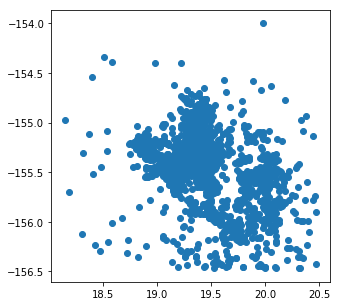

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(lat, lon)
plt.show()

# WOVODAT PuuOo Data

In [6]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

p = PuuOo(eruption_csv_path)
time, lat, lon, depth, mag = load_puuoo_eqs(eq_csv_path)

In [7]:
# Try some random times. Was PuuOo erupting?
print(p.was_erupting(time[1000]))
print(p.was_erupting(time[680]))

# Special case for time < time of first eruption
print('\nSpecial case:')
print(p.was_erupting(time[0]))
p.was_erupting(time[0], verbose=True)

False
True

Special case:
None
Time 1983-01-01 00:18:51 is before eruption history begins


### Remove eqs that happened before eruption history

In [8]:
from itertools import compress

def prune_data(time, lat, lon, depth, mag, puuoo):
    """
    Prune data by removing all eqs that happened before eruption catalogue starts
    WARNING: be careful with datatypes (assumes you want list for time and numpy array for other vars)
    """

    idx = [puuoo.was_erupting(t) is not None for t in time]
    
    time     = list(compress(time, idx))
    lat   = np.array(list(compress(lat, idx)))
    lon   = np.array(list(compress(lon, idx)))
    depth = np.array(list(compress(depth, idx)))
    mag   = np.array(list(compress(mag, idx)))
    
    return time, lat, lon, depth, mag

In [9]:
print(len(time))
time, lat, lon, depth, mag = prune_data(time, lat, lon, depth, mag, p)
print(len(time))

6485
6397


In [10]:
# Make additional array for erupting or not
erupt = np.array([p.was_erupting(t) for t in time])

### Plot some things

In [11]:
np.sum(erupt==True)

756

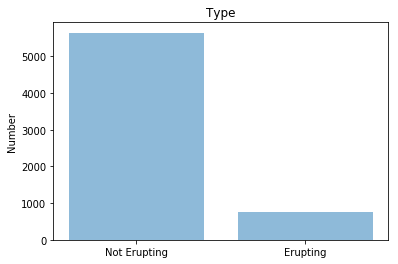

In [12]:
# Number of events
labels = ('Not Erupting', 'Erupting')
y_pos = np.arange(len(labels))
vals = [np.sum(erupt==False), np.sum(erupt==True)]

plt.bar(y_pos, vals, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Type')

plt.show()


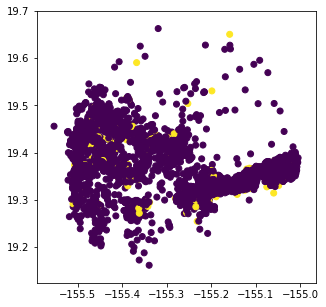

In [13]:
# Geographic distribution
c = [1 if val==True else 0 for val in erupt]
plt.figure(figsize=(5,5))
plt.scatter(lon, lat, c=c)
plt.show()

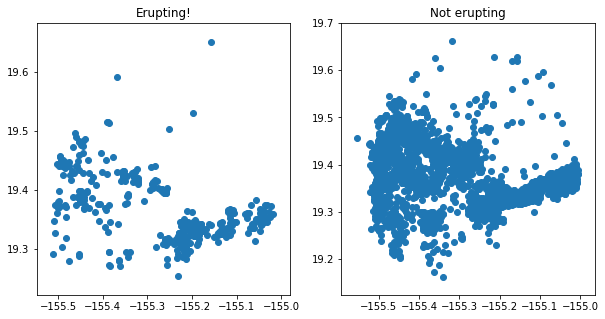

In [14]:
# Pull apart data
lon_erupt   = np.array(list(compress(lon, erupt)))
lat_erupt   = np.array(list(compress(lat, erupt)))

lon_repose   = np.array(list(compress(lon, (1 - erupt))))
lat_repose   = np.array(list(compress(lat, (1 - erupt))))

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.scatter(lon_erupt, lat_erupt)
plt.title('Erupting!')
ax1 = plt.subplot(122)
plt.scatter(lon_repose, lat_repose)
plt.title('Not erupting')
plt.show()

## Machine Learning!
Here's how to run random forest. So easy!! My suspicion is that this model is overfitting the training set, but we need to construct a validation/test set to really know.

In [15]:
timestamp = np.array([t.timestamp() for t in time])

X = np.vstack((timestamp, lat, lon, depth, mag)).T
Y = np.array([1 if val==True else 0 for val in erupt])
print(X.shape)
print(Y.shape)

(5821, 5)
(5821,)


In [16]:
rf = ml_models.RandomForestClassifier(n_estimators=50, max_depth=20)
rf.fit(X, Y) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
def get_accuracy(model, X, Y):
    num_train = Y.shape[0]
    pred     = model.predict(X)
    accuracy = np.sum((pred==Y))/num_train
    
    return accuracy

In [18]:
naive = np.sum(1-Y)/Y.shape[0]
print("Model accuracy:")
print(get_accuracy(rf, X,Y))
print("\nNaive model would get:")
print(naive)
print('\nFeature importances:')
print(rf.feature_importances_)

Model accuracy:
0.9919257859474317

Naive model would get:
0.9250987802783027

Feature importances:
[0.39317324 0.16113825 0.16543683 0.1605171  0.11973459]


### Can we get the same performance without time?

In [40]:
X = np.vstack((lat, lon, depth, mag)).T
Y = np.array([1 if val==True else 0 for val in erupt])
print(X.shape)
print(Y.shape)

(6397, 4)
(6397,)


In [20]:
rf = ml_models.RandomForestClassifier(n_estimators=50, max_depth=20)
rf.fit(X, Y) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
naive = np.sum(1-Y)/Y.shape[0]
print("Model accuracy:")
print(get_accuracy(rf, X,Y))
print("\nNaive model would get:")
print(naive)
print('\nFeature importances:')
print(rf.feature_importances_)

Model accuracy:
0.9883181583920289

Naive model would get:
0.9250987802783027

Feature importances:
[0.2672168  0.27777079 0.25926188 0.19575052]


### Split into Train/Dev

In [64]:
import random

# Make additional array for erupting or not
erupt = np.array([p.was_erupting(t) for t in time])

random.seed(0)
percent_train = 0.8

# Get indices of eruption and non-eruption earthquakes so we can split both
eruption_idx    = [i for i, e in enumerate(erupt) if e == True]
no_eruption_idx = [i for i, e in enumerate(erupt) if e == False]

num_train_eruptions = int(percent_train * len(eruption_idx))
num_val_eruptions   = len(eruption_idx) - num_train_eruptions

num_train_no_eruptions = int(percent_train * len(no_eruption_idx))
num_val_no_eruptions   = len(no_eruption_idx) - num_train_eruptions

train_idx = sorted(random.sample(eruption_idx, num_train_eruptions))
val_idx   = sorted(list(set(eruption_idx) - set(train_idx)))
train_idx += sorted(random.sample(no_eruption_idx, num_train_no_eruptions))
val_idx   += sorted(list(set(no_eruption_idx) - set(train_idx)))

# Shuffle for random feed into model during training
random.shuffle(train_idx)
random.shuffle(val_idx)

train = X[train_idx,:]
val   = X[val_idx,:]